# Распознавание тематики сайта

## Импорты

In [ ]:
!pip install pyLDAvis
!pip install -U pymorphy2-dicts-ru

In [ ]:
%%capture
!pip install bertopic

In [ ]:
import requests
import bs4
import numpy as np
import pandas as pd

import re
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from bertopic import BERTopic

from wordcloud import WordCloud, STOPWORDS

import spacy

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install pymorphy2

## Парсинг новостей

In [ ]:
main_url = 'https://www.tatar-inform.ru/api/v1/news/getNews?widget_id=33&rubric={rubric}&offset='

In [ ]:
rubrics = ['11']

In [ ]:
links = []
all_news = []

for r in rubrics:
    for i in range(10, 110):
        response = requests.get(main_url.format(rubric=r) + str(i))
        tree = bs4.BeautifulSoup(response.json()['data'], 'html.parser')

        for j in tree.select('.newsList__item'):
            link = j.select_one('a').attrs['href']
            links.append(link)

for link in links:
        news_1 = ''
        response = requests.get(link)
        tree = bs4.BeautifulSoup(response.text, 'html.parser')
        t = tree.select('.page-main__text')[0]
        for j in t.select("p"):
            news_1 += j.text
        all_news.append(news_1)

In [ ]:
print(len(all_news))

1000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(len(links))

1000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
all_news[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Национальный музей Татарстана принял участие в акции «Ночь музеев» и организовал серию мастер-классов. Занятия были совершенно разнонаправленными — от изготовления брелоков из кожи и кукол-оберегов до гончарного мастерства.«Сейчас не время керамики, но этот материал был очень важен для жизни человека. Керамика — первый материал, который человек научился изготавливать сам», — заметила младший научный сотрудник отдела научной реконструкции Евгения Зиланова. Фото: © Анастасия Богданова / «Татар-информ»«Глиняные истории» — именно так назывался мастер-класс, который пользовался большой популярностью у детей. Дело не только в том, что гончарное ремесло считается одним из древнейших. Сама лепка из глины — процесс крайне увлекательный и интересный.Руководитель мастер-класса рассказала о свойствах глины и показала, как с ней можно работать. «По керамике можно сказать, какой народ и когда жил на этой территории. Всё это отражается в форме узоров изделия. На территории Татарстана очень любили зе

In [ ]:
print(links[1])

https://www.tatar-inform.ru/news/kukly-oberegi-i-keramika-v-kazani-prosli-master-klassy-noci-muzeev-5906704


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Токенизация

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True удаляет знаки препинания

Удалим знаки препинания, ненужные символы, приведем слова к нижнему регистру

In [ ]:
data_words = list(sent_to_words(all_news))
print(data_words[1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['национальныи', 'музеи', 'татарстана', 'принял', 'участие', 'акции', 'ночь', 'музеев', 'организовал', 'серию', 'мастер', 'классов', 'занятия', 'были', 'совершенно', 'от', 'изготовления', 'брелоков', 'из', 'кожи', 'кукол', 'оберегов', 'до', 'гончарного', 'мастерства', 'сеичас', 'не', 'время', 'керамики', 'но', 'этот', 'материал', 'был', 'очень', 'важен', 'для', 'жизни', 'человека', 'керамика', 'первыи', 'материал', 'которыи', 'человек', 'научился', 'изготавливать', 'сам', 'заметила', 'младшии', 'научныи', 'сотрудник', 'отдела', 'научнои', 'реконструкции', 'евгения', 'зиланова', 'фото', 'анастасия', 'богданова', 'татар', 'информ', 'глиняные', 'истории', 'именно', 'так', 'назывался', 'мастер', 'класс', 'которыи', 'пользовался', 'большои', 'популярностью', 'детеи', 'дело', 'не', 'только', 'том', 'что', 'гончарное', 'ремесло', 'считается', 'одним', 'из', 'древнеиших', 'сама', 'лепка', 'из', 'глины', 'процесс', 'краине', 'увлекательныи', 'интересныи', 'руководитель', 'мастер', 'класса', 'ра

## Лемматизация

Лемматизация — процесс приведения словоформы к лемме — её нормальной (словарной) форме.

В русском языке нормальными формами считаются следующие морфологические формы:

* для существительных — именительный падеж, единственное число;
* для прилагательных — именительный падеж, единственное число, мужской род;
* для глаголов, причастий, деепричастий — глагол в инфинитиве (неопределённой форме) несовершенного вида.

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='ru')

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(data_arrs):
  result = []
  for arr in data_arrs:
    temp = []
    for words in arr:
      words = words.split()
      gr_words = []
      for word in words:
        gr_words.append(morph.parse(word)[0].normal_form)
        gr_words_str = ''.join(gr_words)
      temp.append(gr_words_str)
    result.append(temp)
  return result

In [ ]:
# Лемматизация
data_lemmatized = lemmatization(data_words)

In [ ]:
print(data_words[1])

['национальныи', 'музеи', 'татарстана', 'принял', 'участие', 'акции', 'ночь', 'музеев', 'организовал', 'серию', 'мастер', 'классов', 'занятия', 'были', 'совершенно', 'от', 'изготовления', 'брелоков', 'из', 'кожи', 'кукол', 'оберегов', 'до', 'гончарного', 'мастерства', 'сеичас', 'не', 'время', 'керамики', 'но', 'этот', 'материал', 'был', 'очень', 'важен', 'для', 'жизни', 'человека', 'керамика', 'первыи', 'материал', 'которыи', 'человек', 'научился', 'изготавливать', 'сам', 'заметила', 'младшии', 'научныи', 'сотрудник', 'отдела', 'научнои', 'реконструкции', 'евгения', 'зиланова', 'фото', 'анастасия', 'богданова', 'татар', 'информ', 'глиняные', 'истории', 'именно', 'так', 'назывался', 'мастер', 'класс', 'которыи', 'пользовался', 'большои', 'популярностью', 'детеи', 'дело', 'не', 'только', 'том', 'что', 'гончарное', 'ремесло', 'считается', 'одним', 'из', 'древнеиших', 'сама', 'лепка', 'из', 'глины', 'процесс', 'краине', 'увлекательныи', 'интересныи', 'руководитель', 'мастер', 'класса', 'ра

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(data_lemmatized[1])

['национальный', 'музей', 'татарстан', 'принять', 'участие', 'акция', 'ночь', 'музей', 'организовать', 'серия', 'мастер', 'класс', 'занятие', 'быть', 'совершенно', 'от', 'изготовление', 'брелок', 'из', 'кожа', 'кукла', 'оберег', 'до', 'гончарный', 'мастерство', 'сеичас', 'не', 'время', 'керамика', 'но', 'этот', 'материал', 'быть', 'очень', 'важный', 'для', 'жизнь', 'человек', 'керамика', 'первыя', 'материал', 'который', 'человек', 'научиться', 'изготавливать', 'сам', 'заметить', 'младшие', 'научный', 'сотрудник', 'отдел', 'научной', 'реконструкция', 'евгений', 'зилановый', 'фото', 'анастасия', 'богданов', 'татарин', 'информ', 'глиняный', 'история', 'именно', 'так', 'называться', 'мастер', 'класс', 'который', 'пользоваться', 'большоя', 'популярность', 'детея', 'дело', 'не', 'только', 'тот', 'что', 'гончарный', 'ремесло', 'считаться', 'один', 'из', 'древнеинуть', 'сам', 'лепка', 'из', 'глина', 'процесс', 'краина', 'увлекательный', 'интересный', 'руководитель', 'мастер', 'класс', 'рассказ

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Удаление стоп-слов

In [ ]:
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = nltk.corpus.stopwords.words('russian')

Добавим стоп-слова, часто встречающиеся в текстах

In [ ]:
new_words=('год', 'это','который', 'также', 'свой', 'информ')
for i in new_words:
    stop_words.append(i)

Уберем слова, состоящие из букв латинского алфавита и цифр

In [ ]:
def remove_words(df, stopwords):
  chars = ['татар', 'a', 'b', 'c', 'd', 'e', 'f', 'j','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','0','1','2','3','4','5','6','7','8','9']
  for arr in df:
    for word in arr:
      for char in chars:
        if (char in word) and (word in arr) and (word not in stopwords):
          stopwords.append(word)

In [ ]:
remove_words(data_lemmatized, stop_words)

In [ ]:
print(stop_words[-5:])

['xi', 'weekend', 'xхii', 'pr', 'qullar']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Убираем стоп-слова
data_words_nostops = remove_stopwords(data_lemmatized)

In [ ]:
data_words_nostops[1][:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['национальный', 'музей', 'принять', 'участие', 'акция']

## Создание биграмм и триграмм

Модель фраз Gensim может создавать и реализовывать биграммы, триграммы, квадрограммы и многое другое. Реализуем биграммы с ее помощью.
Двумя важными аргументами фраз являются min_count и threshold. Чем выше значения этих параметров, тем сложнее объединить слова в биграммы.

In [ ]:
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
print(bigram_mod[bigram_mod[data_words_nostops[1]]])

['национальный', 'музей', 'принять', 'участие', 'акция', 'ночь', 'музей', 'организовать', 'серия', 'мастер', 'класс', 'занятие', 'совершенно', 'изготовление', 'брелок', 'кожа', 'кукла', 'оберег', 'гончарный', 'мастерство', 'сеичас', 'время', 'керамика', 'материал', 'очень', 'важный', 'жизнь', 'человек', 'керамика', 'первыя', 'материал', 'человек', 'научиться', 'изготавливать', 'заметить', 'младшие', 'научный', 'сотрудник', 'отдел_научной', 'реконструкция', 'евгений', 'зилановый', 'фото', 'анастасия_богданов', 'глиняный', 'история', 'именно', 'называться', 'мастер', 'класс', 'пользоваться', 'большоя', 'популярность', 'детея', 'дело', 'гончарный', 'ремесло', 'считаться', 'древнеинуть', 'лепка', 'глина', 'процесс', 'краина', 'увлекательный', 'интересный', 'руководитель', 'мастер', 'класс', 'рассказать', 'своиство', 'глина', 'показать', 'нея', 'работать', 'керамик', 'сказать', 'народ', 'жить', 'территория', 'всё', 'отражаться', 'форма', 'узор', 'изделие', 'территория', 'очень', 'любить', '

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Определим функцию для создания биграмм и вызовем ее

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
data_words_bigrams = make_bigrams(data_words_nostops)

In [ ]:
data_words_bigrams[1][:30]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['национальный',
 'музей',
 'принять',
 'участие',
 'акция',
 'ночь',
 'музей',
 'организовать',
 'серия',
 'мастер',
 'класс',
 'занятие',
 'совершенно',
 'изготовление',
 'брелок',
 'кожа',
 'кукла',
 'оберег',
 'гончарный',
 'мастерство',
 'сеичас',
 'время',
 'керамика',
 'материал',
 'очень',
 'важный',
 'жизнь',
 'человек',
 'керамика',
 'первыя']

# Создадим словарь и корпус

Двумя основными входными данными для тематической модели LDA являются словарь (id2word) и корпус. Создаем их.

In [ ]:
id2word = corpora.Dictionary(data_words_bigrams)
# Создаем корпус
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 3), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 1), (110, 1)

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('акцентировать', 1),
  ('алсу', 1),
  ('арт', 3),
  ('аюдаг', 1),
  ('бард', 1),
  ('бардовский', 1),
  ('бежать', 1),
  ('бэхэта', 1),
  ('валеев', 1),
  ('валерий', 1),
  ('вечер', 2),
  ('взаимоотношение', 1),
  ('вокалист', 2),
  ('вокальный', 1),
  ('волна', 1),
  ('всероссииский', 1),
  ('всё', 1),
  ('вход', 1),
  ('входить', 1),
  ('выступление', 1),
  ('георгин', 1),
  ('гостея', 2),
  ('группа', 1),
  ('друг', 1),
  ('дуэт', 2),
  ('елена', 3),
  ('женщина', 1),
  ('жизнь', 1),
  ('известность', 1),
  ('известный', 1),
  ('излюбить', 1),
  ('исполнение', 1),
  ('исполнить', 1),
  ('италия', 1),
  ('казанский', 1),
  ('казанцев', 1),
  ('картина', 3),
  ('китаиския', 1),
  ('китая', 1),
  ('композитор', 1),
  ('конкурс', 1),
  ('концерт', 1),
  ('которой', 1),
  ('краиновый', 1),
  ('красный', 2),
  ('культурный', 1),
  ('лад_аюдаг', 2),
  ('лада_аюдаг', 2),
  ('ладик', 1),
  ('лампа', 1),
  ('лауреат', 1),
  ('листопад', 1),
  ('любовь', 2),
  ('лян', 1),
  ('май', 1),
  (

# Построим тематическую модель

LDA(Latent Dirichlet Allocation — Латентное размещение Дирихле) - это метод, который  позволяет определить скрытые тематики в тексте, предполагая, что эти темы сформированы на основании вероятности вхождения слова из заданного текста. LDA можно рассматривать как метод «мягкой» кластеризации – текст может относится к той или иной тематике с определённой вероятностью.

In [ ]:
# LDA
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 6.08 s, sys: 19.3 ms, total: 6.1 s
Wall time: 6.22 s


Модель LDA построена на 5 различных темах, где каждая тема представляет собой комбинацию ключевых слов, и каждое ключевое слово вносит определенный вес в тему.

Можно увидеть ключевые слова для каждой темы и вес каждого ключевого слова, используя lda_model.print_topics().

In [ ]:
lda_model.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.033*"музей" + 0.028*"выставка" + 0.011*"композитор" + 0.011*"оркестр" + 0.009*"художник" + 0.008*"представить" + 0.008*"мастер" + 0.008*"фото" + 0.007*"джаз" + 0.006*"май"'),
 (1,
  '0.018*"фестиваль" + 0.018*"театр" + 0.013*"спектакль" + 0.008*"артист" + 0.008*"песня" + 0.007*"фильм" + 0.006*"режиссёр" + 0.006*"май" + 0.006*"рассказать" + 0.006*"стать"'),
 (2,
  '0.015*"выставка" + 0.011*"культура" + 0.009*"фото" + 0.008*"музей" + 0.008*"россия" + 0.008*"владимир" + 0.007*"мир" + 0.007*"весь" + 0.007*"искусство" + 0.007*"форум"'),
 (3,
  '0.013*"фильм" + 0.009*"фото" + 0.008*"проект" + 0.007*"руководитель" + 0.007*"рт" + 0.007*"произведение" + 0.007*"создать" + 0.006*"время" + 0.006*"наш" + 0.006*"весь"'),
 (4,
  '0.016*"театр" + 0.014*"культура" + 0.012*"коллектив" + 0.011*"воин" + 0.011*"народный" + 0.010*"конкурс" + 0.010*"рт" + 0.010*"национальный" + 0.009*"раион" + 0.009*"проект"')]

## Вычислим сложность модели и ее когерентности

Cложность (Perplexity) модели и согласованность (Coherence) темы предоставляют удобную меру для оценки того, насколько хорошо выполнено тематическое моделирование.

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.2094084546709

Coherence Score:  0.2838457284765197


## Визуализация темы и ключевых слов

Визуализируем темы при помощи интерактивной диаграммы пакета pyLDAvis.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.081750 -0.110206       1        1  24.903258
4     -0.037681 -0.228241       2        1  20.452897
1     -0.190331  0.130447       3        1  19.572501
3     -0.109885  0.076609       4        1  18.608197
2      0.256147  0.131390       5        1  16.463147, topic_info=           Term         Freq        Total Category  logprob  loglift
177       музей  1755.000000  1755.000000  Default  30.0000  30.0000
473    выставка  1699.000000  1699.000000  Default  29.0000  29.0000
645       театр  1128.000000  1128.000000  Default  28.0000  28.0000
374   фестиваль   613.000000   613.000000  Default  27.0000  27.0000
309       фильм   628.000000   628.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
394  заповедник   118.692080   349.449016   Topic5  -5.3819   0.7242
227     человек   115.240071   398.050961   Topic5  -5.4115   0.5645
115    художник   117.881047   594.495903   Topic5  -5.3888   0.1860
322     галерея   101.698296   272.195665   Topic5  -5.5365   0.8195
176        мочь    99.901065   245.635735   Topic5  -5.5543   0.9044

[363 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
451       1  0.048340          автор
451       2  0.328018          автор
451       3  0.462678          автор
451       4  0.158830          автор
2269      4  0.974086  администрация
...     ...       ...            ...
4433      1  0.985402  юрий_щербаков
127       1  0.019955           язык
127       2  0.115742           язык
127       3  0.447003           язык
127       4  0.415074           язык

[615 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 4, 3])

## Как найти оптимальное количество тем для LDA?

Подход к поиску оптимального количества тем состоит в том, чтобы построить множество моделей LDA с разными значениями количества тем (k) и выбрать ту, которая дает наибольшее значение когерентности.

Выбор ‘k’, обозначающий конец быстрого роста согласованности тем, обычно предлагает значимые и интерпретируемые темы. Выбор более высокого значения иногда может дать более детальные подтемы.

Функция сompute_coherence_values () обучает несколько моделей LDA и предоставляет модели и соответствующие им оценки когерентности.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


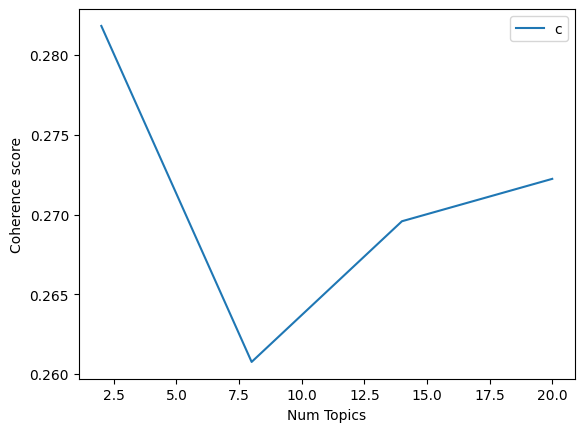

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## LDA из sklearn

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

Используя CountVectorizer, генерируем матрицу, которая обозначает частоту слов каждого текста

In [ ]:
count_vect = CountVectorizer(analyzer=lambda x: x, lowercase=True)
x_counts = count_vect.fit_transform(data_words_bigrams)

In [ ]:
x_counts.todense()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
count_vect.get_feature_names_out()[20:4000:100]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['авторской', 'альбин_нугмановой', 'аудиозапись',
       'благословение_патриарх', 'бытовой_сценка', 'виа_волга', 'волков',
       'выидти', 'гидонь', 'гульнара_мансуровафото', 'детския',
       'достоверность', 'жанр_ушея', 'закупить_огромный', 'зилановый',
       'икона', 'исполнительница', 'карпов', 'колоссальный_влияние',
       'кровля_устроиство', 'ленком', 'мальчик_судьба', 'мечеть_кул',
       'музеищик_реализовать', 'накануне', 'недомогание', 'нтр', 'одежда',
       'основой', 'оцифровывать', 'пересекаться_временной',
       'повредить_фрагмент', 'политический_происхождение',
       'поставить_гидроизоляция', 'представитель', 'приобщение_молодёжь',
       'простой_подписаться', 'размер', 'редёр', 'россииской_зарубежной'],
      dtype=object)

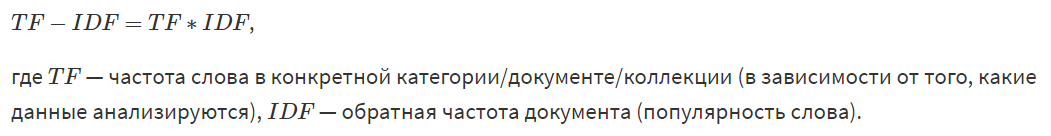

In [ ]:
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vect.get_feature_names_out(),columns=["idf_weights"])

df_idf.sort_values(by=['idf_weights'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,idf_weights
май,1.678273
стать,1.773190
представить,1.808436
музей,1.842647
фото,1.854315
...,...
экспозиционный,7.215608
рафис,7.215608
оборудование,7.215608
пополняться,7.215608


Чем меньше значение IDF для слова, тем менее уникальным оно является для любого конкретного документа.

In [ ]:
lda2 = LDA(n_components = 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
%%time
lda_array = lda2.fit_transform(x_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



CPU times: user 2.26 s, sys: 6.62 ms, total: 2.27 s
Wall time: 3.12 s


Если сравнивать реальное время, то LDA из sklearn работает быстрее

Если сравнивать процессорное время, то LDA из sklearn работает быстрее

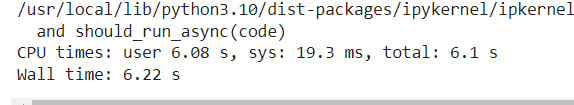

In [ ]:
n_top_words = 10
print("\nTopics in LDA model: ")
tf_feature_names = count_vect.get_feature_names_out()
print_top_words(lda2, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:музей фильм фестиваль национальный мастер джаз предоставить книжный заповедник рак

Topic #1:музей место культура инсталляция кремль выставка объект фото рт композитор

Topic #2:выставка музей мир ислам заповедник свияжск искусство галерея россия живой

Topic #3:кандинский художник выставка музей конкурс праздничный_салют картина казань фестиваль концерт

Topic #4:театр спектакль май программа сказка выставка музей альметьевский форум режиссёр

Topic #5:проект художник композитор культура работа скульптура музей модельер праздник фото


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
np.exp(-1. * lda_model.log_perplexity(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1352.0922122402005

In [ ]:
print(lda2.perplexity(x_tfidf))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



8629.338145663562


Чем меньше perplexity, тем лучше модель. Можем видеть, что модель LDA из gensim лучше, так как ее perplexity = 1352, когда у модели из sklearn perplexity = 8629

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Topic #0


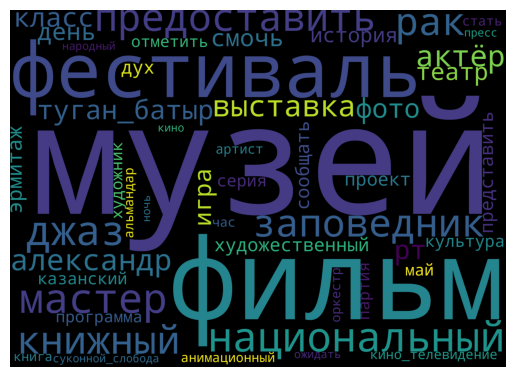

Topic #1


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



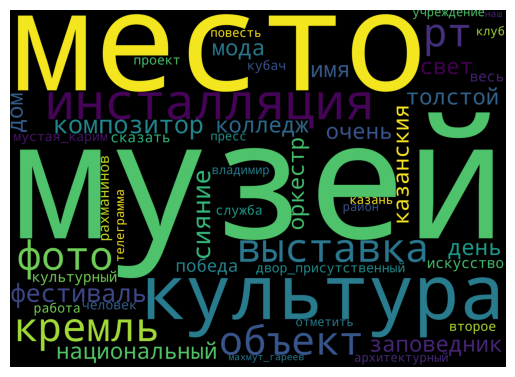

Topic #2


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



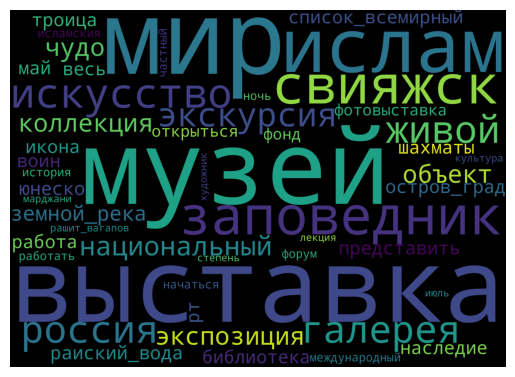

Topic #3


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



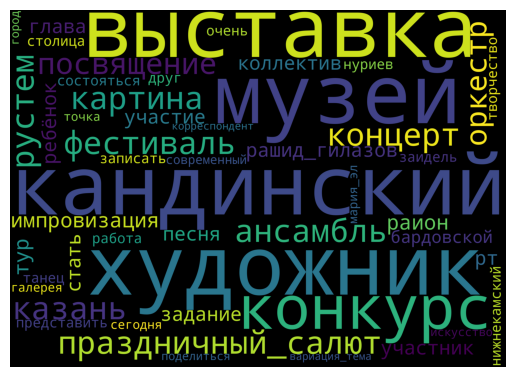

Topic #4


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



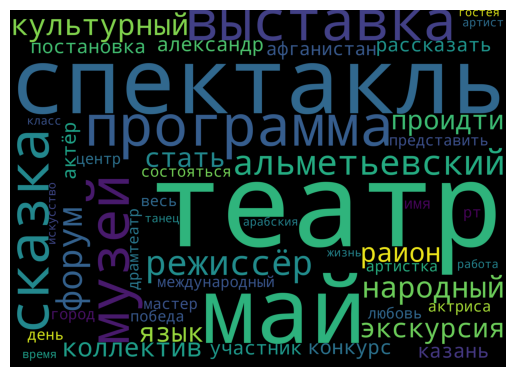

In [ ]:
for topic in range(0, 5):
    print(f'Topic #{topic}')
    topic = lda2.components_[topic]
    topic_words = [tf_feature_names[i] for i in topic.argsort()[:-50 - 1 :-1]]

    cloud = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='black',
                              width=2500,
                              height=1800
                            ).generate(" ".join(topic_words))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

## BERTopic

это метод тематического моделирования, который использует transformers и c-TF-IDF для создания плотных кластеров, позволяющих легко интерпретировать темы, сохраняя при этом важные слова в описаниях тем

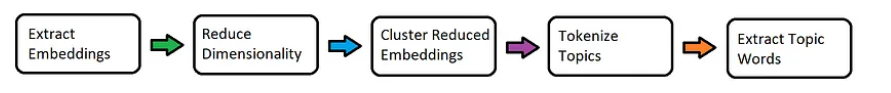

In [ ]:
bertopic_news = []
for news in data_words_bigrams:
    n = ""
    for w in news:
        n = n + w + " "
    bertopic_news.append(n)

In [ ]:
topic_model = BERTopic(language="russian", calculate_probabilities=True, verbose=True)

In [ ]:
%%time
topics, probs = topic_model.fit_transform(bertopic_news)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-05-24 10:48:13,224 - BERTopic - Transformed documents to Embeddings
2023-05-24 10:48:30,565 - BERTopic - Reduced dimensionality
2023-05-24 10:48:30,734 - BERTopic - Clustered reduced embeddings


CPU times: user 2min 54s, sys: 24.9 s, total: 3min 19s
Wall time: 3min 23s


Рассматрим наиболее часто встречающиеся темы, поскольку они наилучшим образом отражают набор документов.

In [ ]:
freq = topic_model.get_topic_info()
freq.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topic,Count,Name
0,-1,40,-1_модельер_жизнь_владимир_уйти
1,0,77,0_песня_конкурс_место_артист
2,1,70,1_воин_махмут_гареев_подготовка_рождение
3,2,59,2_кандинский_джаз_выставка_композитор
4,3,56,3_театр_актриса_фильм_анимационный
5,4,50,4_композитор_оркестр_саф_радио
6,5,47,5_дух_фестиваль_суконной_слобода_кукла_экият
7,6,46,6_скульптура_художник_выставка_кубач
8,7,43,7_музей_толстой_бал_лев
9,8,40,8_раион_праздник_культура_землячество


-1 относится ко всем выбросам и, как правило, должно игнорироваться

Далее, давайте взглянем на часто задаваемую тему, которая была сгенерирована:

In [ ]:
topic_model.get_topic(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[('песня', 0.04407645051093669),
 ('конкурс', 0.03382366208973863),
 ('место', 0.03010204963692103),
 ('артист', 0.02741603456632887),
 ('колледж', 0.027044058326165403),
 ('коллектив', 0.024680006436969226),
 ('ансамбль', 0.02370354477144863),
 ('рашит_вагапов', 0.023493673298770258),
 ('народный', 0.023239002801041856),
 ('творчество', 0.021619375978350924)]

Мы можем визуализировать выбранные термины для нескольких тем, создав столбчатые диаграммы на основе оценок tf-IDF для представления каждой темы. Информацию можно получить из относительных оценок c-TF-IDF между темами и внутри них

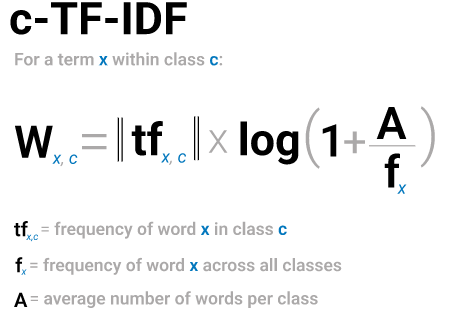

In [ ]:
topic_model.visualize_barchart(top_n_topics=12)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Можем визуализировать темы, которые были сгенерированы способом, очень похожим на LDAvis

8

In [ ]:
topic_model.visualize_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Созданные темы могут быть иерархически сокращены. Чтобы понять потенциальную иерархическую структуру тем, мы можем использовать scipy.cluster.hierarchy для создания кластеров и визуализации того, как они связаны друг с другом. Это может помочь выбрать подходящий nr_topics при сокращении количества созданных тем

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=29)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.10/dist-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.10/dist-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.10/dist-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning:


In [ ]:
topic_model2 = BERTopic(language="russian", calculate_probabilities=True, verbose=True, nr_topics=8)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
%%time
topics2, probs2 = topic_model2.fit_transform(bertopic_news)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-05-24 11:59:57,341 - BERTopic - Transformed documents to Embeddings
2023-05-24 12:00:07,925 - BERTopic - Reduced dimensionality
2023-05-24 12:00:08,053 - BERTopic - Clustered reduced embeddings
2023-05-24 12:00:11,586 - BERTopic - Reduced number of topics from 31 to 9


CPU times: user 3min 49s, sys: 6.01 s, total: 3min 55s
Wall time: 3min 1s


In [ ]:
freq = topic_model2.get_topic_info()
freq.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topic,Count,Name
0,-1,17,-1_владимир_мхат_юнона_авось_алексеевич_кузнецов
1,0,543,0_музей_выставка_фестиваль_рт
2,1,156,1_театр_фильм_режиссёр_спектакль
3,2,103,2_композитор_оркестр_кандинский_выставка
4,3,76,3_выставка_мир_ислам_музей
5,4,36,4_рак_эрмитаж_нижнекамский_передача
6,5,30,5_троица_икона_андрей_рублёв_президент
7,6,20,6_женщина_мода_дарья_саифиева_деловой
8,7,19,7_могила_похоронить_память_диана_батршина


In [ ]:
topic_model2.visualize_barchart(top_n_topics=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
topic_model2.visualize_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

